# Homework 3

This is a homework assignment on the material from the 10th-15th classes. The deadline for submission is __23:59 on December 18__.

- The homework is done in the same Jupyter Notebook.

- The file should be renamed: __Group Number_First Name_Last Name__ (no spaces at the beginning or end). Example: __000_Ivan_Ivanov__.

- Homework should be sent to __OptimizationHomework@yandex.ru__. Subject line: __Innopolis_Task number__ (without spaces at the beginning and end). For this assignment, the subject line is: __Innopolis_3__.

- Place the solution to each problem/item after the condition.

- Do not forget to add necessary explanations and comments.

- All technical artifacts should be removed in the final version that will be sent for checking. By such artifacts we mean any cell outputs that are not commented in any way in the text, as well as any bulk/long technical output (even if it is commented in the text).

- A full run of the solution (Kernel -> Restart & Run All) should run all cells without errors.

- The maximum score for the assignment is 100.

We wish you success!

### Part 1. Solving the unconstrained optimization problem

Consider again the empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the batch size, $s$ is the number of batches, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})}.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

Let us do some preparation work. The _mushrooms_ dataset is attached. Use the following code to generate a matrix $X$ and vector $y$, which will store the sample $\{x_i, y_i\}_{i=1}^n$:

In [1]:
import numpy as np
from numpy.typing import ArrayLike

dataset = "mushrooms.txt"
from lovely_numpy import lo
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)
import time

# the file must be in the same directory as notebook.

In [2]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [3]:
y = 2 * y - 3

Let us divide the data into two parts: train and test.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient of $f$ ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them).

In [5]:
def sigmoid(x: ArrayLike) -> np.float32:
    return 1 / (1 + np.exp(-x))


def logistic(
    w: ArrayLike, # M
    X: ArrayLike = X_train, # N x M
    y: ArrayLike = y_train, # N
    reg_lambda: np.float32 = 0,
) -> np.float32:
    n = X.shape[0]
    z = X @ w  # Matrix multiplication of X and w, z will be a column vector
    l = np.log(1 + np.exp(-y * z))  # Vectorized computation for all elements
    f = np.mean(l) + (reg_lambda / 2) * np.linalg.norm(w) ** 2
    return f


def logistic_grad(
    w: ArrayLike, # M
    X: ArrayLike = X_train, # N x M
    y: ArrayLike = y_train, # N
    reg_lambda: np.float32 = 0,
) -> ArrayLike:
    n = X.shape[0]

    # Calculate the sigmoid values for all samples
    z = X @ w
    sigmoid_vals = sigmoid(-y * z)

    # Compute the gradient
    error = sigmoid_vals * (-y)
    grad = X.T @ error
    grad /= n

    # Add the regularization term
    regularization_term = reg_lambda * w
    grad += regularization_term

    return grad


def logistic_hessian(
    w: ArrayLike, # M
    X: ArrayLike = X_train, # N x M
    y: ArrayLike = y_train, # N
    reg_lambda: np.float32 = 0,
) -> ArrayLike:
    n = X.shape[0]
    d = X.shape[1]

    # Compute the sigmoid values
    z = X @ w
    sigmoid_vals = sigmoid(z)

    # Calculate the diagonal matrix of the second derivatives
    D = np.diag(sigmoid_vals * (1 - sigmoid_vals))

    # Compute the Hessian
    hessian = X.T @ D @ X

    # Add regularization term to the diagonal elements
    regularization_matrix = reg_lambda * np.identity(d)
    hessian /= n
    hessian += regularization_matrix
    return hessian

In [6]:
def logistic_smoothness(X, reg_lambda=0):
    L = 0
    n = X.shape[0]
    L = np.max(
        np.linalg.eigvalsh(X.T @ X)
    )  # X here have shape (n, d), so we should transpose both X's
    L /= 4 * n
    L += reg_lambda
    return L


L_wo_reg = logistic_smoothness(X_train)
reg_lambda = L_wo_reg / 1000
print(f"Regularizer value λ - {reg_lambda}")
L_with_reg = logistic_smoothness(X_train, reg_lambda)
L_wo_reg, L_with_reg

Regularizer value λ - 0.002584638862872305


(2.584638862872305, 2.5872235017351777)

__Problem 0. (5 points)__  Implement the ability to uniformly divide the training part of the dataset into batches of size $b$ ($b$ is a parameter).

In [7]:
def batch_split_data(data: ArrayLike, b: int) -> ArrayLike:
    if b == 1:
        return np.expand_dims(data, axis=1)
    n, m = data.shape
    # drop last batch, to satisfy the equal shapes
    truncated_data = data[: -(n % b)]
    batched_data = np.reshape(truncated_data, (n // b, b , m))
    return batched_data

def batch_split_labels(data: ArrayLike, b: int) -> ArrayLike:
    if b == 1:
        return np.expand_dims(data, axis=1)
    n = data.shape[0]
    # drop last batch, to satisfy the equal shapes
    truncated_data = data[: -(n % b)]
    batched_data = np.reshape(truncated_data, (n // b, b))
    return batched_data

batch_split_data(X_train, 1).shape, batch_split_labels(y_train, 1).shape

((6499, 1, 112), (6499, 1))

__Problem 1. (50 points)__ This part of the assignment is related to __non-distributed stochastic__ methods.

__a). (5 points)__ Implement the SGD method:
$$
w^{k+1} = w^k - \gamma_k \nabla f_{j_k} (w^k),
$$
where the number $j_k$ is generated independently and uniformly from $\{1, \ldots, s \}$.

Just in case, we give here a variant of the function description for the gradient descent from the first assignment. You can use this format if you wish. Note that ``x_sol`` occurs in the code - this problem should be solved or criteria tied to ``x_sol`` should not be used.

In [8]:
X_train_batched = batch_split_data(X_train, 10)
y_train_batched = batch_split_labels(y_train, 10)

In [9]:
def model_predictions(w, X=X_test):
    result = (
        X @ w.T
    )  # get model results and take a sigmoid over it to get class probabilities
    result[result >= 0] = 1  # greater then 0 -> class is 1
    result[result < 0] = -1  # less then 0 -> class is -1
    return result


def calc_accuracy(y_pred, y_true=y_test):
    return np.sum(y_pred == y_true) / len(y_true)


def stochasctic_grad_descent(
    f,  # Objective function to be minimized.
    nabla_f,  # Gradient (or derivative) of the objective function.
    x_0,  # Initial guess or starting point for optimization.
    alpha,  # Learning rate (step size) for gradient descent.
    K=10**3,  # Maximum number of iterations.
    eps=1e-3,  # Convergence threshold.
    reg=0,  # Regularization parameter (default is 0).
    X=None,  # Optional input data for the objective function.
    y=None,  # Optional target values for the objective function.
    acc=False,  # calculate accuracy on each iteration
    count_gradient_evals=False,  # count number of gradient calls instead of iterations
    iter_dependent_alpha=False,  # use iteration dependent alpha
):
    # Initialize the previous and current solutions.
    x_k = x_0
    batch_id = np.random.randint(0, X.shape[0])

    # Calculate the initial gradient norm.
    init_grad_norm = np.linalg.norm(nabla_f(x_k, X[batch_id], y[batch_id], reg))

    # Record the initial time for optimization time calculation.
    init_time = time.time()

    # Initialize lists to track optimization progress.
    history = [init_grad_norm]
    if count_gradient_evals:
        history = [init_grad_norm for _ in range(X.shape[1])]
    time_tiks = [0]
    accs = []
    if acc:
        pred = model_predictions(x_k)
        cur_accuracy = calc_accuracy(pred)
        if count_gradient_evals:
            accs = [cur_accuracy for _ in range(X.shape[1])]
        else:
            accs.append(cur_accuracy)

    progress = tqdm(range(1, K + 1))

    for k in progress:
        batch_id = np.random.randint(0, X.shape[0])
        step_gradient = nabla_f(x_k, X[batch_id], y[batch_id], reg)
        if iter_dependent_alpha:
            alpha_value = alpha(k)
        else:
            alpha_value = alpha(X[batch_id], reg)

        # Calculate the next solution using gradient descent with momentum.
        x_k_next = x_k - alpha_value * step_gradient

        # Calculate the loss using the updated solution.
        loss = f(x_k_next, X[batch_id], y[batch_id], reg)

        # Calculate the normalized gradient norm.
        grad_norm = np.linalg.norm(step_gradient) / init_grad_norm

        # Check for convergence based on the gradient norm.
        is_converge = grad_norm <= eps

        if is_converge:
            # If convergence is achieved, record the progress and time.
            history.append(grad_norm)
            time_tiks.append(time.time() - init_time)
            if acc:
                pred = model_predictions(x_k)
                cur_accuracy = calc_accuracy(pred)
                if count_gradient_evals:
                    accs = accs + [cur_accuracy for _ in range(X.shape[1])]
                else:
                    accs.append(cur_accuracy)
            return x_k_next, np.array(history), k, time_tiks, accs

        progress.set_description(f"Loss {loss:.3e}, Grad norm {grad_norm:.3e}")

        # Update previous and current solutions.
        x_k = x_k_next
        if count_gradient_evals:
            history = history + [grad_norm for _ in range(X.shape[1])]
        else:
            history.append(grad_norm)
        time_tiks.append(time.time() - init_time)
        if acc:
            pred = model_predictions(x_k)
            cur_accuracy = calc_accuracy(pred)
            if count_gradient_evals:
                accs = accs + [cur_accuracy for _ in range(X.shape[1])]
            else:
                accs.append(cur_accuracy)

    return x_k, np.array(history), K, time_tiks, accs

__b). (7 points)__ Solve the optimization problem on the training sample using the implemented method. Take $b = 10$, and the step is $\gamma_k \equiv \frac{1}{\tilde L}$. From the point of view of the theory, what should be taken as $\tilde L$? Draw the convergence plot: the value of the convergence criterion ($\frac{\| \nabla f(w^k)\|}{\| \nabla f(w^0)\|}$) from the iteration number. Make a conclusion.

The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

In [10]:
def get_smoothness_estimation(batch, reg):
    norm =  np.sum(np.linalg.norm(batch, axis=1))
    batch_size = len(batch)
    L = norm / (4 * batch_size)
    L += reg
    return L

def get_alpha(batch, reg):
    L = get_smoothness_estimation(batch, reg)
    return 1/L

In [11]:
w_0 = np.random.rand(X_train.shape[1])

w_trained, hist, steps, t, acc_res = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=get_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
)

y_pred_train = model_predictions(w_trained, X_train)
y_pred_test = model_predictions(w_trained, X_test)
print(f"accuracy of test set: {calc_accuracy(y_pred_test, y_test)}")
print(f"accuracy of train set: {calc_accuracy(y_pred_train, y_train)}")

Loss 8.029e-02, Grad norm 6.084e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1064.65it/s]


accuracy of test set: 0.9907692307692307
accuracy of train set: 0.9884597630404678


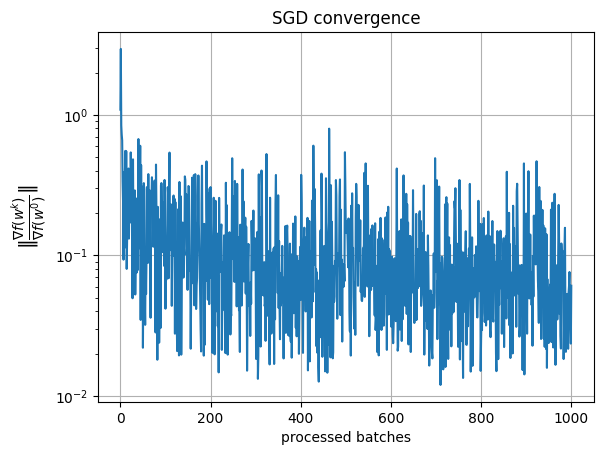

In [12]:
plt.plot(hist)
plt.title('SGD convergence')
plt.xlabel('processed batches')
plt.ylabel('$ \| \\frac{\\nabla f(w^k)}{\\nabla f(w^0)} \|$', fontsize=14)
plt.grid()
plt.yscale('log')

At some point close to the solution method became oscilating and diverges. So we need to apply some techniques, which will improve the performance of the method, then the criteria value becomes relatevely small.

__c). (7 points)__ Vary the batch size: $b = 1, 10, 100, 1000$, and take the step size equal to $\gamma_k \equiv \frac{1}{\tilde L}$ (note that $\tilde L$ need to be recalculated for each $b$). Draw the convergence plot: the value of the convergence criterion from the iteration number for each $b$. Does this plot reflect a fair comparison? Why? Figure out how to compare the results to each other more honestly (running time is a good option, but you can't use it here) and draw a new comparison plot. Make a conclusion.

In [13]:
w_0 = np.random.rand(X_train.shape[1])
bs = [1, 10, 100, 1000]

crit_hists = []

for b in bs:
    X_train_batched_cur = batch_split_data(X_train, b)
    y_train_batched_cur = batch_split_labels(y_train, b)

    w_trained, hist, steps, t, acc_res = stochasctic_grad_descent(
        logistic,
        logistic_grad,
        w_0,
        alpha=get_alpha,
        K=10**3,
        reg=reg_lambda,
        X=X_train_batched_cur,
        y=y_train_batched_cur,
        count_gradient_evals=True
    )

    y_pred_train = model_predictions(w_trained, X_train)
    y_pred_test = model_predictions(w_trained, X_test)
    print(f"accuracy of test set: {calc_accuracy(y_pred_test, y_test)}")
    print(f"accuracy of train set: {calc_accuracy(y_pred_train, y_train)}")
    crit_hists.append(hist)

Loss 1.061e-01, Grad norm 4.188e+00: 100%|██████████| 1000/1000 [00:00<00:00, 1090.44it/s]


accuracy of test set: 0.9889230769230769
accuracy of train set: 0.9886136328665949


Loss 7.338e-02, Grad norm 2.853e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1056.01it/s]


accuracy of test set: 0.9975384615384615
accuracy of train set: 0.9978458224342206


Loss 8.061e-02, Grad norm 1.291e-02: 100%|██████████| 1000/1000 [00:02<00:00, 465.07it/s]


accuracy of test set: 0.9969230769230769
accuracy of train set: 0.9949222957378058


Loss 8.017e-02, Grad norm 3.884e-03: 100%|██████████| 1000/1000 [00:05<00:00, 177.72it/s]


accuracy of test set: 0.9944615384615385
accuracy of train set: 0.9943068164332974


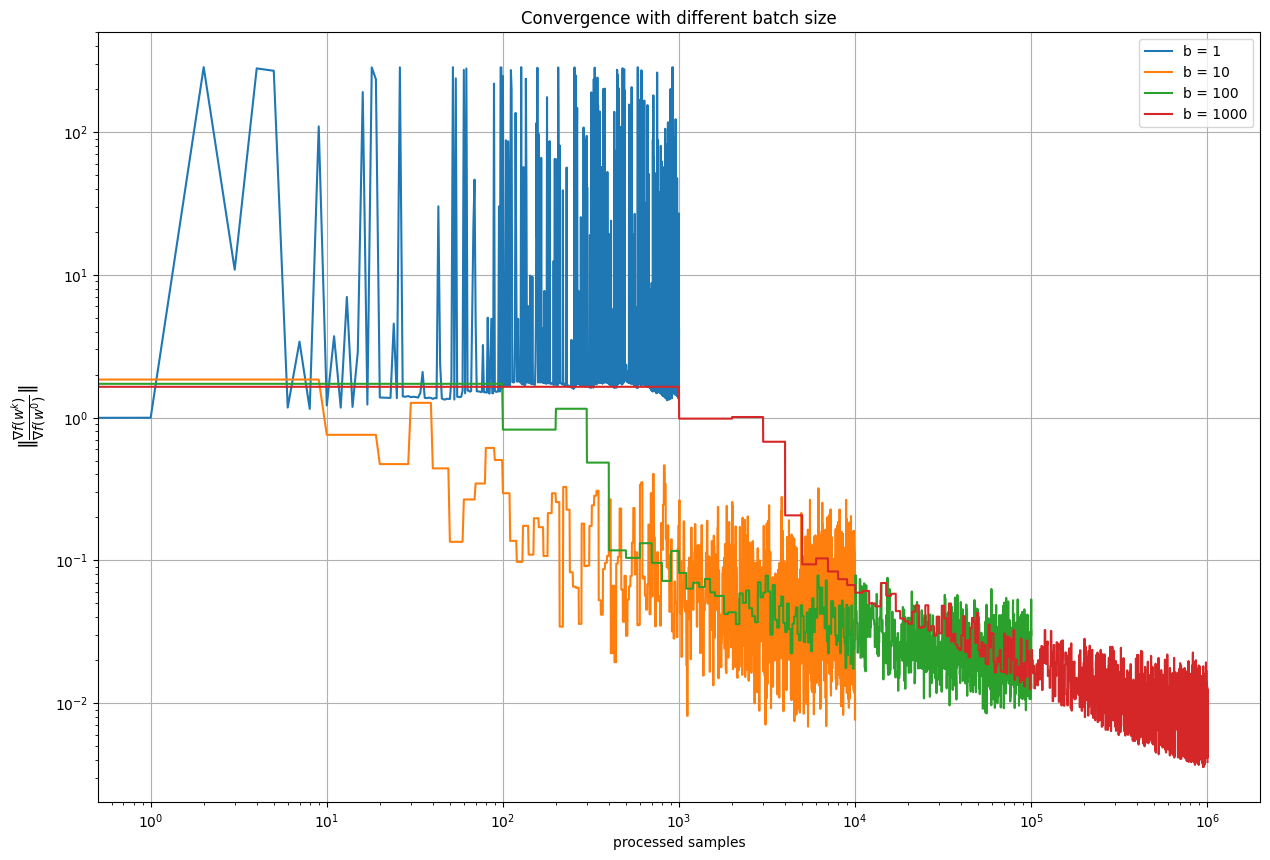

In [14]:
plt.figure(figsize=(15,10))

for i, hist in enumerate(crit_hists):
    legend = f"b = {bs[i]}"
    plt.plot(hist, label=legend)

plt.title('Convergence with different batch size')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('processed samples')
plt.ylabel('$ \| \\frac{\\nabla f(w^k)}{\\nabla f(w^0)} \|$', fontsize=14)
plt.show()

To make a fair comparison we can consider the number of processed samples instead of the number of iterations. With this method we take into a consideration the batch size of the method. 

So we can see that the method with the batch size $1000$ oscillates less than the others. But it takes $10^6$ times more samples to process. And the method with $b = 100$ achieves the almost same result with $10$ times less samples. So we can conclude that the method with $b = 100$ is the best in this case.

__d). (6 points)__ Let us fix $b = 10$ and try to change the strategy of choosing the step:

1) $\gamma_k \equiv \frac{1}{\tilde L}$ as we did before,

2) $\gamma_k \equiv \text{const}$, selecting $\text{const}$ to get the "best" convergence (explain what you mean by "best"),

3) $\gamma_k = \frac{1}{\sqrt{k + 1}}$, 

4) $\gamma_k = \frac{1}{k + 1}$.

Draw the convergence plot: the value of the convergence criterion from the iteration number. Make a conclusion.

In [15]:
X_train_batched.shape, y_train_batched.shape

((649, 10, 112), (649, 10))

In [16]:
alpha = get_alpha(X_train_batched[0], reg_lambda)
alpha_min = alpha # 1/L
alpha_max = alpha * 2  # 2/L

possible_alphas = np.linspace(alpha_min, alpha_max, 10)

alpha_min, alpha_max

(0.8709067450247419, 1.7418134900494837)

In [17]:
hists = []

for alpha in possible_alphas:
    def get_alpha_const(batch, reg):
        return alpha
    w_trained, hist, steps, t, acc_res = stochasctic_grad_descent(
        logistic,
        logistic_grad,
        w_0,
        alpha=get_alpha_const,
        K=10**3,
        reg=reg_lambda,
        X=X_train_batched,
        y=y_train_batched,
    )

    y_pred_train = model_predictions(w_trained, X_train)
    y_pred_test = model_predictions(w_trained, X_test)
    print(f"min criterion value: {np.min(hist):.3e}")
    print(f"criterion STD: {np.std(hist):.3e}")
    print('='*75)
    hists.append(hist)

Loss 7.969e-02, Grad norm 6.515e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1478.07it/s]


min criterion value: 1.180e-02
criterion STD: 1.413e-01


Loss 1.033e-01, Grad norm 9.275e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1327.56it/s]


min criterion value: 9.085e-03
criterion STD: 1.008e-01


Loss 9.273e-02, Grad norm 2.807e-01: 100%|██████████| 1000/1000 [00:00<00:00, 1245.71it/s]


min criterion value: 9.083e-03
criterion STD: 1.103e-01


Loss 6.827e-02, Grad norm 3.839e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1279.64it/s]


min criterion value: 8.451e-03
criterion STD: 1.004e-01


Loss 6.639e-02, Grad norm 3.919e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1247.18it/s]


min criterion value: 7.377e-03
criterion STD: 9.675e-02


Loss 5.057e-02, Grad norm 2.619e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1203.34it/s]


min criterion value: 1.001e-02
criterion STD: 9.632e-02


Loss 6.584e-02, Grad norm 6.132e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1315.49it/s]


min criterion value: 4.513e-03
criterion STD: 9.771e-02


Loss 6.683e-02, Grad norm 6.906e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1242.90it/s]


min criterion value: 6.184e-03
criterion STD: 8.977e-02


Loss 6.368e-02, Grad norm 2.057e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1266.09it/s]


min criterion value: 5.066e-03
criterion STD: 1.019e-01


Loss 6.399e-02, Grad norm 7.205e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1213.61it/s]


min criterion value: 5.494e-03
criterion STD: 9.601e-02


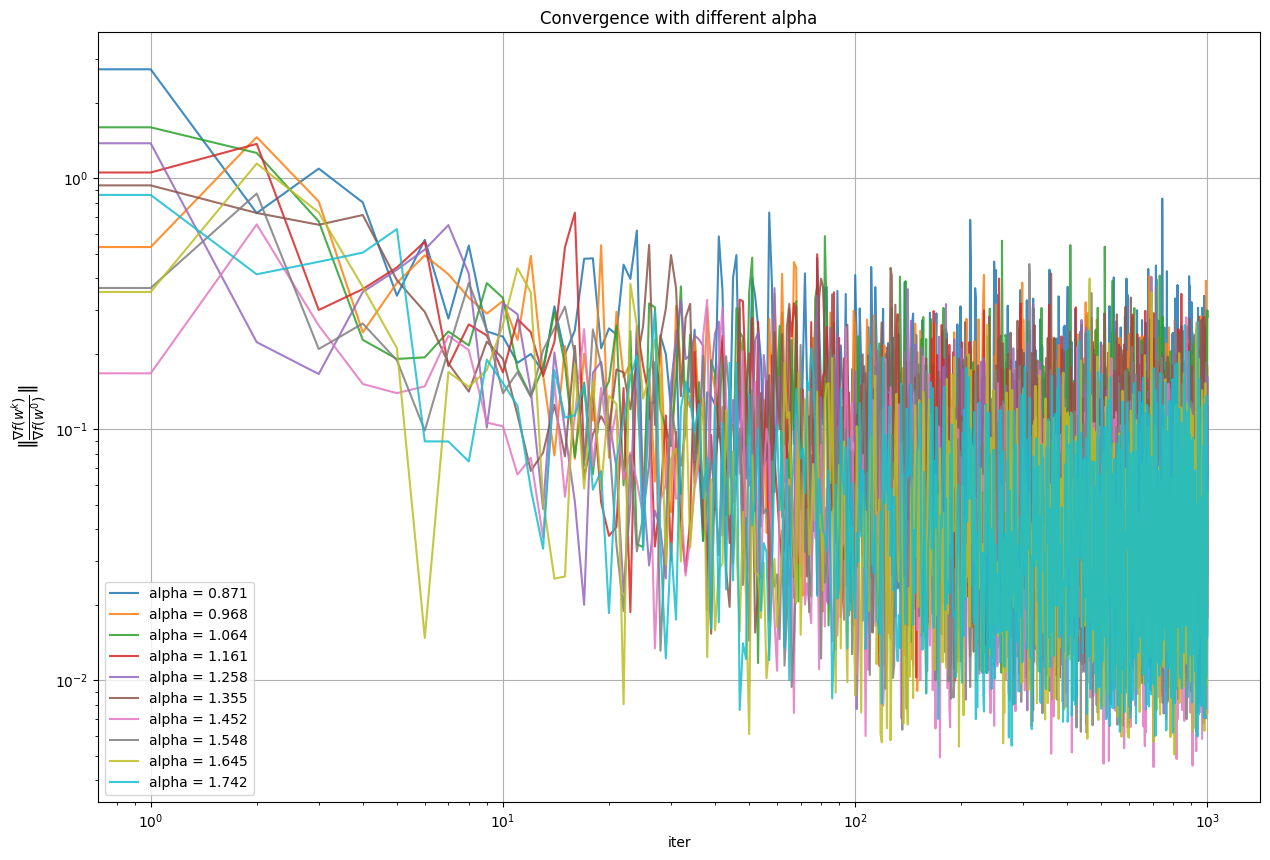

In [18]:
plt.figure(figsize=(15,10))

for i, hist in enumerate(hists):
    legend = f"alpha = {possible_alphas[i]:.3f}"
    plt.plot(hist, label=legend, alpha=0.85)

plt.title('Convergence with different alpha')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('iter')
plt.ylabel('$ \| \\frac{\\nabla f(w^k)}{\\nabla f(w^0)} \|$', fontsize=14)
plt.show()

In [19]:
def step_alpha(step):
    return 1 / (step + 1)

def sqrt_step_alpha(step):
    return 1 / np.sqrt(step + 1)

def const_alpha(step):
    return 1.742

w_0 = np.random.rand(X_train.shape[1])

w_trained, hist_1, steps, t, acc_res = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=step_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
    iter_dependent_alpha=True
)

w_trained, hist_2, steps, t, acc_res = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=sqrt_step_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
    iter_dependent_alpha=True
)

w_trained, hist_3, steps, t, acc_res = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=get_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
)

w_trained, hist_4, steps, t, acc_res = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=const_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
    iter_dependent_alpha=True
)

Loss 6.450e-02, Grad norm 2.494e-02: 100%|██████████| 1000/1000 [00:00<00:00, 1309.00it/s]


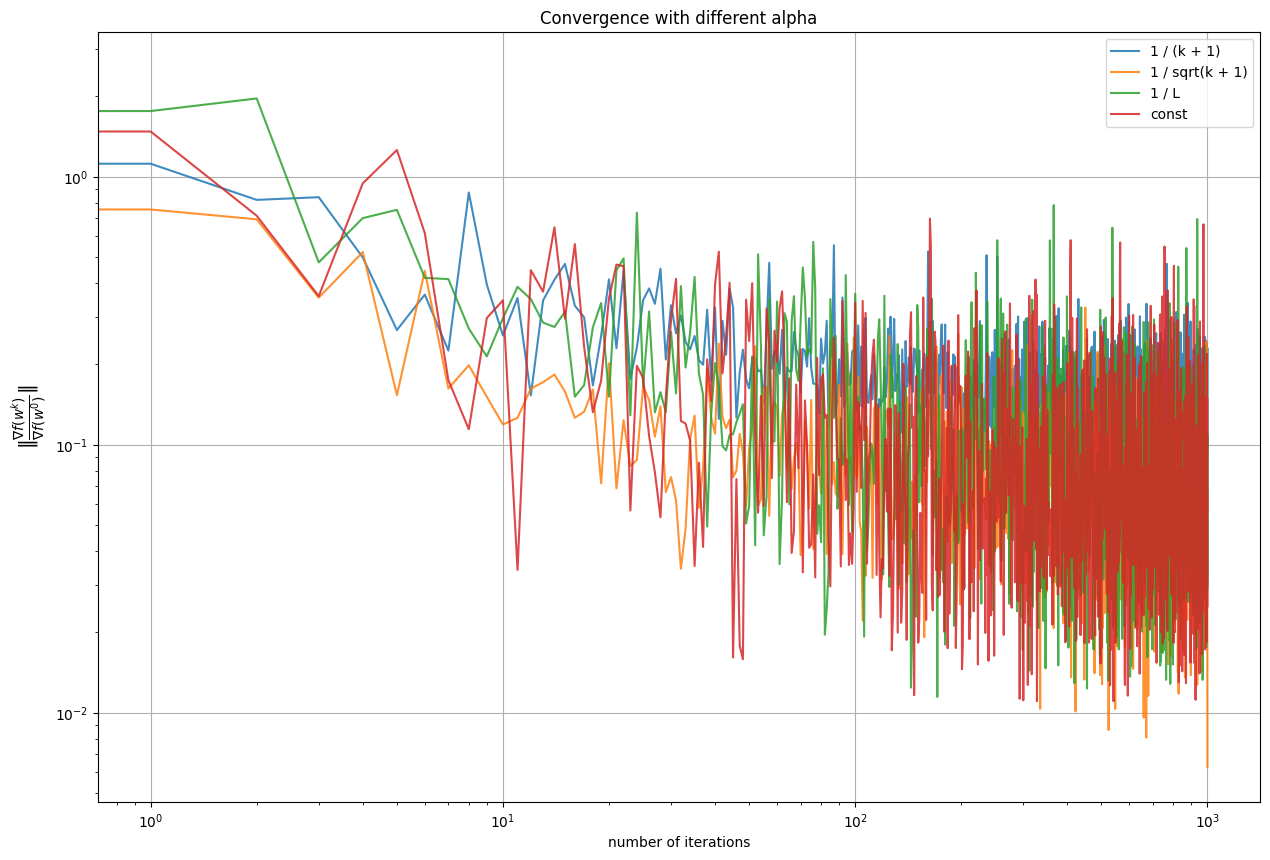

In [20]:
plt.figure(figsize=(15,10))
plt.plot(hist_1, label="1 / (k + 1)", alpha=0.85)
plt.plot(hist_2, label="1 / sqrt(k + 1)", alpha=0.85)
plt.plot(hist_3, label="1 / L", alpha=0.85)
plt.plot(hist_4, label="const", alpha=0.85)
plt.title('Convergence with different alpha')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('number of iterations')
plt.ylabel('$ \| \\frac{\\nabla f(w^k)}{\\nabla f(w^0)} \|$', fontsize=14)
plt.show()

__e). (5 points)__ In the previous hometask, we used the obtained solution of the optimization problem to predict answers on a test sample. Recall the essence: the original regression problem is a machine learning problem and using a linear model $g$ we can predict the values of labels $y$. Suppose we have a sample $x_i$, the model response for this sample is $g(w^*, x^i)$. Then the predictive rule can be formulated in the following rather natural way:
$$
y_i = 
\begin{cases}
1, & g(w^*, x^i) \geq 0,
\\
-1, & g(w^*, x^i) < 0.
\end{cases}
$$
By making predictions on the test sample $X_{test}$, we can compare the result with the real labels $y_{test}$. The number of correctly guessed labels is the accuracy of the model.

Look at the accuracy of the model trained with SGD. Repeat point c)-d), but now plot the accuracy dependence, not the convergence criterion. Make a conclusion.

In [21]:
w_0 = np.random.rand(X_train.shape[1])
bs = [1, 10, 100, 1000]

crit_hists = []

for b in bs:
    X_train_batched_cur = batch_split_data(X_train, b)
    y_train_batched_cur = batch_split_labels(y_train, b)

    w_trained, hist, steps, t, acc_res = stochasctic_grad_descent(
        logistic,
        logistic_grad,
        w_0,
        alpha=get_alpha,
        K=10**3,
        reg=reg_lambda,
        X=X_train_batched_cur,
        y=y_train_batched_cur,
        acc=True,
        count_gradient_evals=True
    )

    y_pred_train = model_predictions(w_trained, X_train)
    y_pred_test = model_predictions(w_trained, X_test)
    print(f"accuracy of test set: {calc_accuracy(y_pred_test, y_test)}")
    print(f"accuracy of train set: {calc_accuracy(y_pred_train, y_train)}")
    crit_hists.append(acc_res)

Loss 1.237e-01, Grad norm 5.523e-03: 100%|██████████| 1000/1000 [00:02<00:00, 480.80it/s]


accuracy of test set: 0.8295384615384616
accuracy of train set: 0.8433605170026158


Loss 7.500e-02, Grad norm 1.454e-01: 100%|██████████| 1000/1000 [00:01<00:00, 648.80it/s]


accuracy of test set: 0.9932307692307693
accuracy of train set: 0.9926142483458994


Loss 7.905e-02, Grad norm 2.390e-02: 100%|██████████| 1000/1000 [00:02<00:00, 413.91it/s]


accuracy of test set: 0.9969230769230769
accuracy of train set: 0.9956916448684413


Loss 8.027e-02, Grad norm 4.723e-03: 100%|██████████| 1000/1000 [00:06<00:00, 143.78it/s]


accuracy of test set: 0.9950769230769231
accuracy of train set: 0.9947684259116787


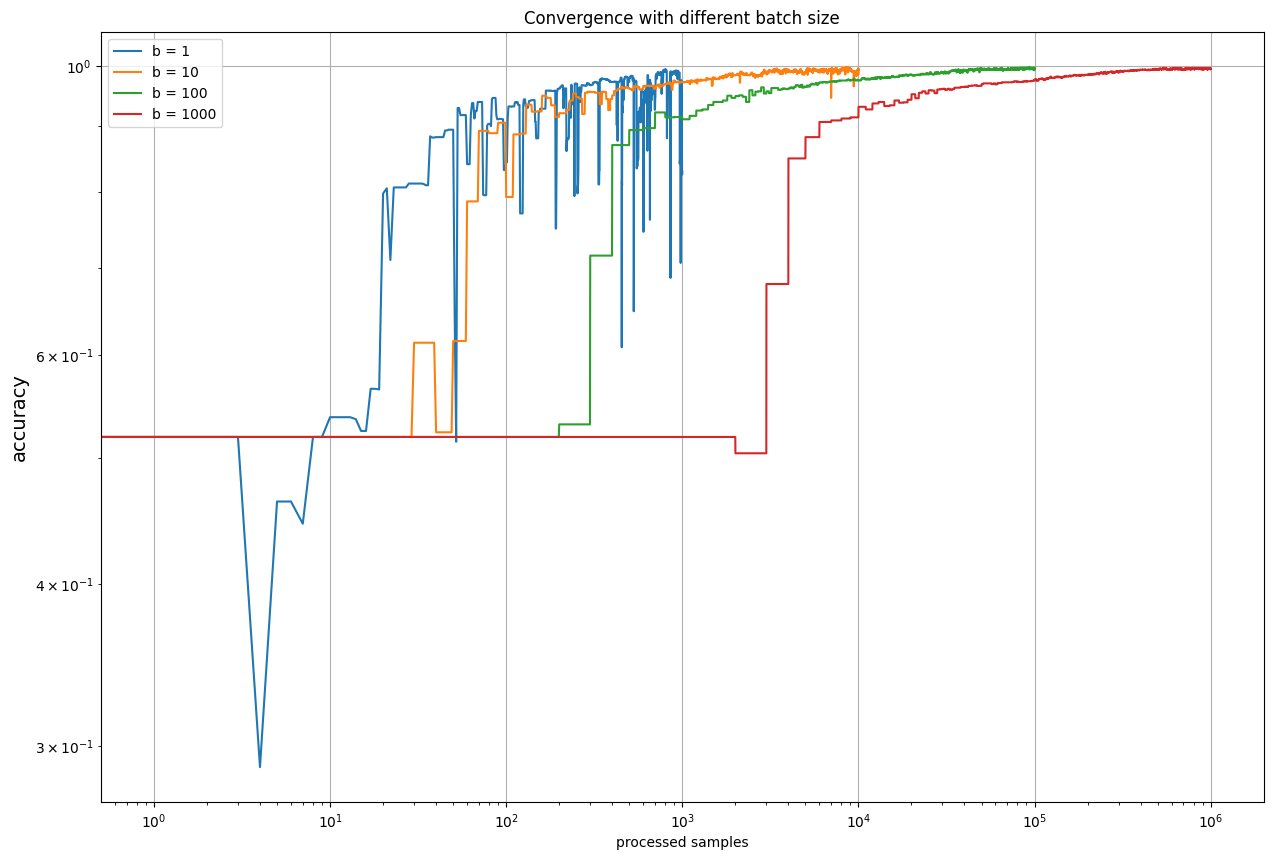

In [22]:
plt.figure(figsize=(15,10))

for i, hist in enumerate(crit_hists):
    legend = f"b = {bs[i]}"
    plt.plot(hist, label=legend)

plt.title('Convergence with different batch size')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('processed samples')
plt.ylabel('accuracy', fontsize=14)
plt.show()

In [23]:
def step_alpha(step):
    return 1 / (step + 1)

def sqrt_step_alpha(step):
    return 1 / np.sqrt(step + 1)

def const_alpha(step):
    return 1.742

w_0 = np.random.rand(X_train.shape[1])

w_trained, hist, steps, t, acc_res_1 = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=step_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
    iter_dependent_alpha=True,
    acc=True
)

w_trained, hist, steps, t, acc_res_2 = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=sqrt_step_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
    iter_dependent_alpha=True,
    acc=True
)

w_trained, hist_3, steps, t, acc_res_3 = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=get_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
    acc=True
)

w_trained, hist_4, steps, t, acc_res_4 = stochasctic_grad_descent(
    logistic,
    logistic_grad,
    w_0,
    alpha=const_alpha,
    K=10**3,
    reg=reg_lambda,
    X=X_train_batched,
    y=y_train_batched,
    iter_dependent_alpha=True,
    acc=True
)

Loss 1.125e-01, Grad norm 3.522e-01: 100%|██████████| 1000/1000 [00:02<00:00, 473.90it/s]


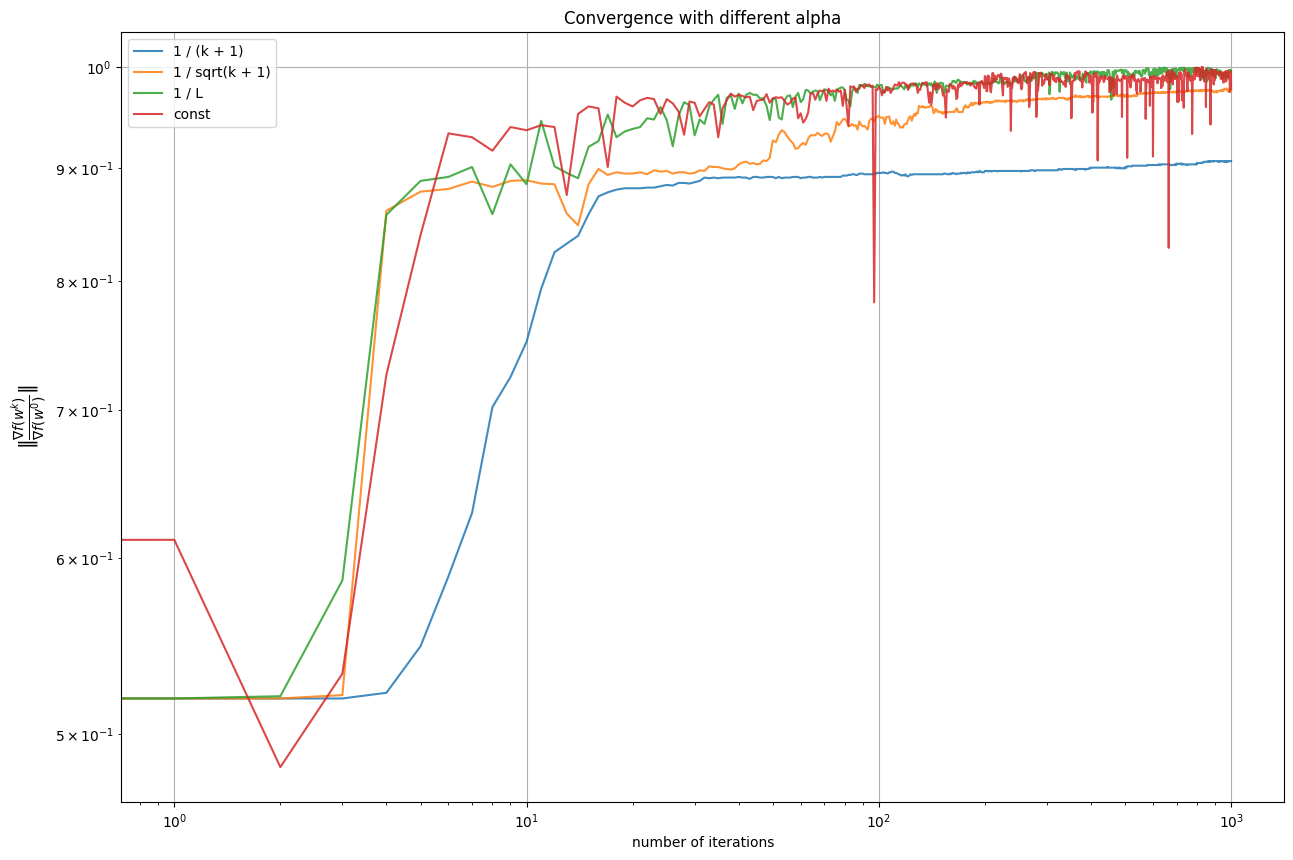

In [24]:
plt.figure(figsize=(15,10))
plt.plot(acc_res_1, label="1 / (k + 1)", alpha=0.85)
plt.plot(acc_res_2, label="1 / sqrt(k + 1)", alpha=0.85)
plt.plot(acc_res_3, label="1 / L", alpha=0.85)
plt.plot(acc_res_4, label="const", alpha=0.85)
plt.title('Convergence with different alpha')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('number of iterations')
plt.ylabel('$ \| \\frac{\\nabla f(w^k)}{\\nabla f(w^0)} \|$', fontsize=14)
plt.show()

`mashrooms` dataset can be easily separated by a hyperplane, so the accuracy of almost all methods is almost $100\%$. But we can see that the method with $b = 100$ achieves the almost same result with $10$ times less samples. So we can conclude that the method with $b = 100$ is the best in this case.

And comparing different stepsize strategies we can see that the results with $\gamma = \frac{1}{\tilde L}$ and $\gamma = \text{const}$ are almost the same, but $\frac{1}{L}$ is more stable. And methods with iterations-dependent stepsize are worse.

__f). (30 points)__ Implement the SAGA (Section A.5 of [paper](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (Section А.9 from [работы](https://arxiv.org/pdf/1905.11261.pdf)) and SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)) methods for our problem. Solve the optimization problem on the training sample using the new implemented methods. Take $b = 10$, and hyperparameters of methods according to the theory (see corresponding papers). Write these parameters. Is the iteration number a fair for comparison of these methods? Figure out how to compare the results more honestly (running time is a good option, but you can't use it here). Draw the comparison plots of SGD (with step $\gamma_k \equiv \frac{1}{\tilde L}$), SAGA, SVRG and SARAH: 1) value of convergence criterion versus your criterion, 2) accuracy of predictions versus your criterion. Make a conclusion.

In [33]:
def SAGA(
    f,
    nabla_f,
    x_0,
    alpha,
    K=10**3,
    eps=1e-3,
    reg=0,
    X=None,
    y=None,
    acc=False,
    count_gradient_evals=False,
    iter_dependent_alpha=False,
):
    num_batches = X.shape[0]
    batch_size = X.shape[1]
    n_features = X.shape[2]
    x_k = x_0
    grad_memory = np.zeros((num_batches, batch_size, n_features))
    init_grad_norm = np.linalg.norm(nabla_f(x_k, X[0], y[0], reg))
    init_time = time.time()

    history = [init_grad_norm]
    if count_gradient_evals:
        history = [init_grad_norm for _ in range(n_features)]
    time_tiks = [0]
    accs = []
    if acc:
        pred = model_predictions(x_k)
        cur_accuracy = calc_accuracy(pred)
        if count_gradient_evals:
            accs = [cur_accuracy for _ in range(n_features)]
        else:
            accs.append(cur_accuracy)

    progress = tqdm(range(1, K + 1))
    for k in progress:
        batch_id = np.random.randint(0, num_batches)
        step_gradient = nabla_f(x_k, X[batch_id], y[batch_id], reg)

        if iter_dependent_alpha:
            alpha_value = alpha(k)
        else:
            alpha_value = alpha(X[batch_id], reg)
        
        # Compute the full gradient using the memory
        full_gradient = np.mean(grad_memory, axis=(0, 1))

        # Update the gradient memory
        grad_memory[batch_id][sample_id] = step_gradient.copy()

        x_k_next = x_k - alpha_value * (step_gradient - full_gradient + np.mean(full_gradient))

        loss = f(x_k_next, X[batch_id], y[batch_id], reg)
        grad_norm = np.linalg.norm(step_gradient) / init_grad_norm

        is_converge = grad_norm <= eps

        if is_converge:
            history.append(grad_norm)
            time_tiks.append(time.time() - init_time)
            if acc:
                pred = model_predictions(x_k)
                cur_accuracy = calc_accuracy(pred)
                if count_gradient_evals:
                    accs = accs + [cur_accuracy for _ in range(n_features)]
                else:
                    accs.append(cur_accuracy)
            return x_k_next, np.array(history), k, time_tiks, accs

        progress.set_description(f"Loss {loss:.3e}, Grad norm {grad_norm:.3e}")

        x_k = x_k_next
        if count_gradient_evals:
            history = history + [grad_norm for _ in range(n_features)]
        else:
            history.append(grad_norm)
        time_tiks.append(time.time() - init_time)
        if acc:
            pred = model_predictions(x_k)
            cur_accuracy = calc_accuracy(pred)
            if count_gradient_evals:
                accs = accs + [cur_accuracy for _ in range(n_features)]
            else:
                accs.append(cur_accuracy)

    return x_k, np.array(history), K, time_tiks, accs

As in d.2), find the "best" step for SAGA, SVRG, SARAH. Draw the comparison plots for SGD, SAGA, SVRG, SARAH with the "best" steps: 1) convergence criterion value, 2) prediction accuracy. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)

__Problem 2. (25 points)__ This part of the assignment is related to __distributed with compression__ methods.

Let us simulate a distributed  environment. To do this, divide the training sample randomly and uniformly into $s=10$ parts (this was implemented in Problem 0). 

__а). (5 points)__ Implement the $\text{Rand}k$ and $\text{Top}k$ compression operators, where $k$ is a parameter. 

In [ ]:
#your solution  (Code and Markdown)

__b). (10 points)__ Implement simple distributed gradient descent with compression operators. Compress information only from the devices to the server. Use compression operators $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. As in d.2) of Problem 1, find the "best" steps for all cases. Draw the comparison plots with these "best" steps: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution (Code and Markdown)

__c). (10 points)__ Now we use $\text{Top}10\%$ as compression operators. Compress the information only from the devices to the server. Use two methods: regular distributed gradient descent with compression operators, and distributed gradient descent with error feedback technique (see Algorithm 1 from [article](https://arxiv.org/abs/2002.12410)). For each method, select the step for the "best" convergence. Draw the comparison plots with these "best" steps: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [ ]:
#your solution  (Code and Markdown)

__Problem 3. (15 points)__ This part of the assignment is related to __distributed with local steps__ methods.

As in the previous problem we simulate the distributed enviroment with $s = 10$. Implement simple Local GD/FedAvg method (Algorithm 1 of [paper](https://arxiv.org/pdf/1909.04746.pdf)), where you can choose the number of local steps $H$ as a parameter. Vary the number of local steps: $H = 1, 5, 10, 20$. Take hyperparameters of the method according to the theory (see the corresponding paper). Write these parameters. Draw the comparison plots for different $H$: 1) value of convergence criterion versus number of communications, 2) accuracy of predictions versus number of communications. Make a conclusion.

In [ ]:
#your solution  (Code and Markdown)